In [12]:
import numpy as np
import pandas as pd
import re
from ast import literal_eval

# Load the dataset
df = pd.read_csv("Data/borg_traces_data.csv")
print("✅ Dataset loaded:", df.shape)

# Parse cpu_usage_distribution column using regex
def parse_hist(x):
    try:
        # Remove brackets and split by whitespace
        x_clean = re.sub(r'[\[\]]', '', str(x)).strip()
        values = [float(v) for v in re.split(r'\s+', x_clean) if v]
        return np.array(values, dtype=np.float32)
    except:
        return None

# Apply parsing
df['cpu_hist'] = df['cpu_usage_distribution'].apply(parse_hist)

# Truncate to 10 bins only
df['cpu_hist'] = df['cpu_hist'].apply(lambda x: x[:10] if isinstance(x, np.ndarray) and len(x) >= 10 else None)

# Filter rows with all required fields
df_clean = df.dropna(subset=['cpu_hist', 'machine_id', 'failed', 'time']).copy()

print("✅ Truncated and cleaned histograms.")
print("Final usable rows:", len(df_clean))
print("Histogram length check:", df_clean['cpu_hist'].iloc[0].shape)


✅ Dataset loaded: (405894, 34)
✅ Truncated and cleaned histograms.
Final usable rows: 390219
Histogram length check: (10,)


In [13]:
from sklearn.model_selection import train_test_split
import torch

seq_len = 6
X_seq, y_seq = [], []
valid_count = 0
invalid_count = 0

for machine_id, group in df_clean.groupby('machine_id'):
    group = group.sort_values(by='time')
    hists = group['cpu_hist'].tolist()
    labels = group['failed'].tolist()

    for i in range(len(hists) - seq_len + 1):
        seq = hists[i:i+seq_len]
        if all(len(vec) == 10 for vec in seq):  # shape (6, 10)
            X_seq.append(np.stack(seq))
            y_seq.append(labels[i + seq_len - 1])
            valid_count += 1
        else:
            invalid_count += 1

print(f"✅ Valid sequences: {valid_count}")
print(f"❌ Invalid sequences (bad shapes): {invalid_count}")

# Final conversion
X_seq = np.stack(X_seq)
y_seq = np.array(y_seq)

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, stratify=y_seq, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"📦 Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)


✅ Valid sequences: 5657
❌ Invalid sequences (bad shapes): 0
📦 Train: (3959, 6, 10), Val: (849, 6, 10), Test: (849, 6, 10)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTMClassifier(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, num_layers=1, dropout=0.3):
        super(AttentionLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Attention weights
        self.attn = nn.Linear(hidden_dim, 1)

        # Final classification
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        
        # Attention mechanism
        attn_scores = self.attn(lstm_out).squeeze(-1)  # (batch, seq_len)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, seq_len)
        
        # Weighted sum of hidden states
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # (batch, hidden_dim)
        
        logits = self.classifier(context)  # (batch, 2)
        return F.log_softmax(logits, dim=1), attn_weights  # Return attention for explainability


c:\Users\binwa\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 001: Train Loss = 0.6844, Val Loss = 0.6806, Val Acc = 0.8940
Epoch 002: Train Loss = 0.6805, Val Loss = 0.6766, Val Acc = 0.8940
Epoch 003: Train Loss = 0.6765, Val Loss = 0.6725, Val Acc = 0.8940
Epoch 004: Train Loss = 0.6725, Val Loss = 0.6683, Val Acc = 0.8940
Epoch 005: Train Loss = 0.6685, Val Loss = 0.6640, Val Acc = 0.8940
Epoch 006: Train Loss = 0.6637, Val Loss = 0.6596, Val Acc = 0.8940
Epoch 007: Train Loss = 0.6596, Val Loss = 0.6549, Val Acc = 0.8940
Epoch 008: Train Loss = 0.6549, Val Loss = 0.6501, Val Acc = 0.8940
Epoch 009: Train Loss = 0.6500, Val Loss = 0.6450, Val Acc = 0.8940
Epoch 010: Train Loss = 0.6448, Val Loss = 0.6397, Val Acc = 0.8940
Epoch 011: Train Loss = 0.6394, Val Loss = 0.6341, Val Acc = 0.8940
🛑 Early stopping triggered.

✅ Training complete in 0.75 seconds


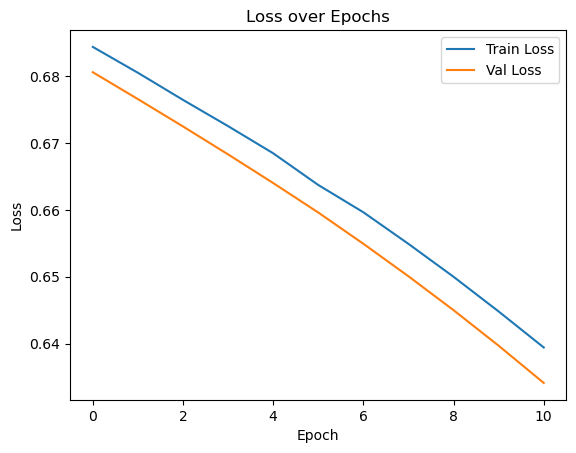

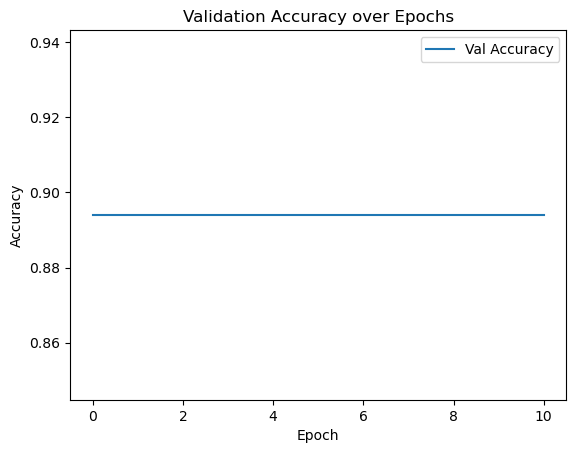

In [15]:
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

model = AttentionLSTMClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

train_losses, val_losses, val_accuracies = [], [], []
best_val_acc = 0
early_stop_patience = 10
patience_counter = 0

start_time = time.time()

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()

    output, _ = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output, _ = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        preds = torch.argmax(val_output, dim=1)
        val_acc = accuracy_score(y_val_tensor.numpy(), preds.numpy())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:03d}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, Val Acc = {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_lstm_attention_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping triggered.")
            break

elapsed = time.time() - start_time
print(f"\n✅ Training complete in {elapsed:.2f} seconds")

# 📊 Save training curves
os.makedirs("visualization", exist_ok=True)
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("visualization/loss_curve_lstm.png")
plt.show()

plt.figure()
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("visualization/val_acc_curve_lstm.png")
plt.show()


📋 Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       760
           1       0.00      0.00      0.00        89

    accuracy                           0.90       849
   macro avg       0.45      0.50      0.47       849
weighted avg       0.80      0.90      0.85       849

🔥 ROC AUC Score: 0.459


c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


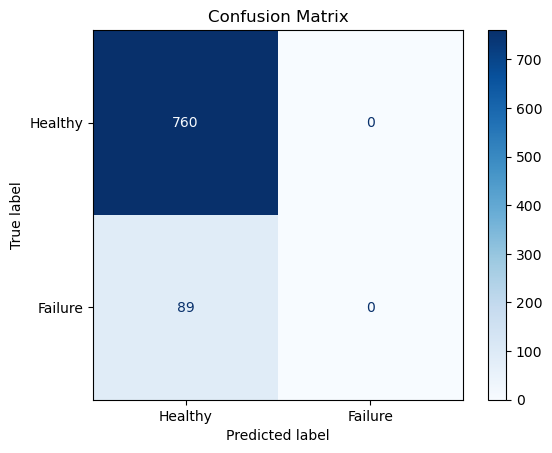

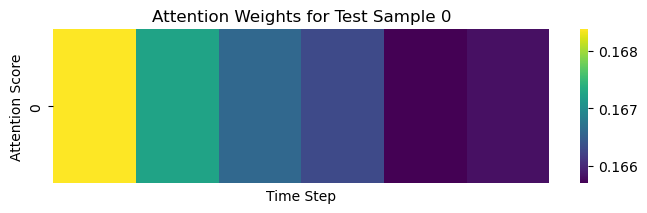

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import seaborn as sns

# Load best model
model.load_state_dict(torch.load("best_lstm_attention_model.pt"))
model.eval()

with torch.no_grad():
    test_output, test_attention = model(X_test_tensor)
    test_preds = torch.argmax(test_output, dim=1)

# ✅ Metrics
print("📋 Classification Report:\n")
print(classification_report(y_test_tensor.numpy(), test_preds.numpy()))

roc_auc = roc_auc_score(y_test_tensor.numpy(), test_output[:, 1].numpy())
print(f"🔥 ROC AUC Score: {roc_auc:.3f}")

# 📊 Confusion Matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Failure"])
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("visualization/confusion_matrix_lstm.png")
plt.show()

# 🧠 Attention Map for One Sample
# 🧠 Attention Map for One Sample (fixed)
sample_idx = 0
sample_input = X_test_tensor[sample_idx].unsqueeze(0)
model.eval()
_, attn_weights = model(sample_input)

plt.figure(figsize=(8, 2))
sns.heatmap(attn_weights.detach().numpy(), cmap='viridis', cbar=True, xticklabels=False)
plt.title(f"Attention Weights for Test Sample {sample_idx}")
plt.xlabel("Time Step")
plt.ylabel("Attention Score")
plt.savefig("visualization/attention_weights_lstm.png")
plt.show()



c:\Users\binwa\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


⚖️ Class Weights: [0.55886505 4.7470024 ]
Epoch 001: Train Loss = 0.6984, Val Acc = 0.8940
Epoch 002: Train Loss = 0.6959, Val Acc = 0.8940
Epoch 003: Train Loss = 0.6953, Val Acc = 0.8940
Epoch 004: Train Loss = 0.6971, Val Acc = 0.8940
Epoch 005: Train Loss = 0.6947, Val Acc = 0.8940
Epoch 006: Train Loss = 0.6952, Val Acc = 0.8940
Epoch 007: Train Loss = 0.6946, Val Acc = 0.8940
Epoch 008: Train Loss = 0.6928, Val Acc = 0.8940
Epoch 009: Train Loss = 0.6950, Val Acc = 0.8940
Epoch 010: Train Loss = 0.6949, Val Acc = 0.1060
Epoch 011: Train Loss = 0.6926, Val Acc = 0.1060
🛑 Early stopping triggered.

✅ Training complete in 0.76 seconds


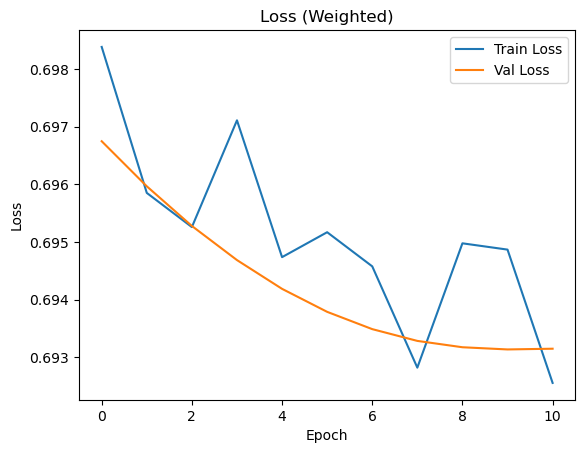

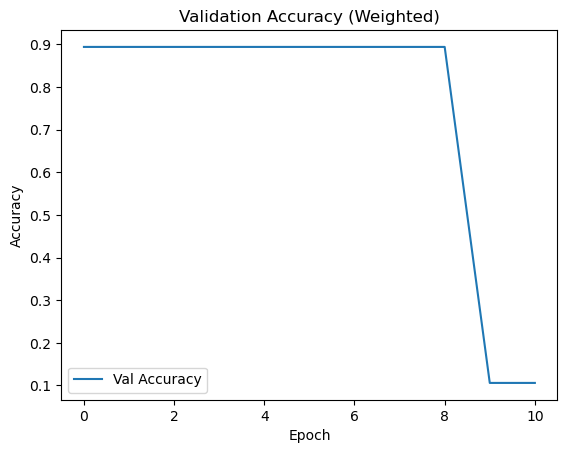

In [18]:
# 🔁 Reinitialize model and optimizer
model = AttentionLSTMClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ✅ Class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print("⚖️ Class Weights:", class_weights)
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.NLLLoss(weight=weight_tensor)

# 🔁 Training with weights
train_losses, val_losses, val_accuracies = [], [], []
best_val_acc = 0
patience_counter = 0
early_stop_patience = 10
start_time = time.time()

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()

    output, _ = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output, _ = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        preds = torch.argmax(val_output, dim=1)
        val_acc = accuracy_score(y_val_tensor.numpy(), preds.numpy())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:03d}: Train Loss = {loss.item():.4f}, Val Acc = {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_lstm_attention_model_weighted.pt")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping triggered.")
            break

elapsed = time.time() - start_time
print(f"\n✅ Training complete in {elapsed:.2f} seconds")

# 📊 Visualization
os.makedirs("visualization", exist_ok=True)
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss (Weighted)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("visualization/loss_curve_lstm_weighted.png")
plt.show()

plt.figure()
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Validation Accuracy (Weighted)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("visualization/val_acc_curve_lstm_weighted.png")
plt.show()


📋 Classification Report (Weighted Loss):

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       760
           1       0.00      0.00      0.00        89

    accuracy                           0.90       849
   macro avg       0.45      0.50      0.47       849
weighted avg       0.80      0.90      0.85       849

🔥 ROC AUC Score (Weighted): 0.561


c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


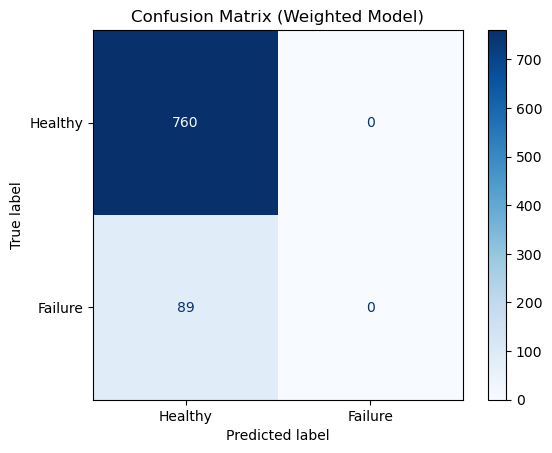

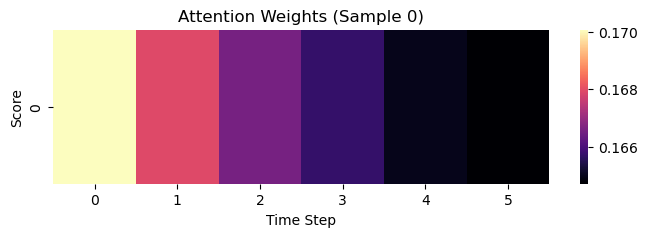

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import seaborn as sns

# ✅ Load best weighted model
model.load_state_dict(torch.load("best_lstm_attention_model_weighted.pt"))
model.eval()

with torch.no_grad():
    test_output, test_attention = model(X_test_tensor)
    test_preds = torch.argmax(test_output, dim=1)

# 📋 Classification Report
print("📋 Classification Report (Weighted Loss):\n")
print(classification_report(y_test_tensor.numpy(), test_preds.numpy()))

# 🔥 ROC AUC
roc_auc = roc_auc_score(y_test_tensor.numpy(), test_output[:, 1].numpy())
print(f"🔥 ROC AUC Score (Weighted): {roc_auc:.3f}")

# 📊 Confusion Matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Failure"])
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix (Weighted Model)")
plt.savefig("visualization/confusion_matrix_lstm_weighted.png")
plt.show()

# 🎯 Attention visualization
sample_idx = 0
sample_input = X_test_tensor[sample_idx].unsqueeze(0)
model.eval()
_, attn_weights = model(sample_input)

plt.figure(figsize=(8, 2))
sns.heatmap(attn_weights.detach().numpy(), cmap='magma', cbar=True)
plt.title(f"Attention Weights (Sample {sample_idx})")
plt.xlabel("Time Step")
plt.ylabel("Score")
plt.savefig("visualization/attention_weights_lstm_weighted.png")
plt.show()
